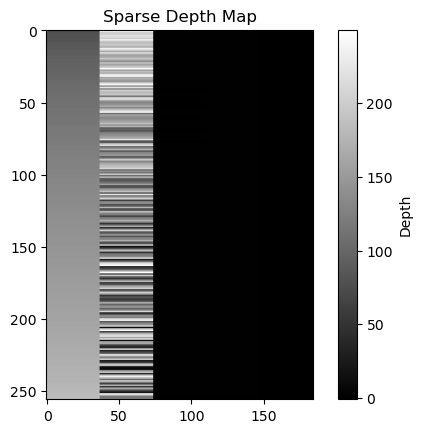

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
from pathlib import Path
import pickle
path = '/home/harshr/NV_cahsor/CAHSOR-master/data/depth_2024-11-26-20-18-08/'
sd = np.load(path+'61_sparse.npy')

s = cv2.resize(sd, (256, 256), interpolation=cv2.INTER_AREA)
#np.save(path+'61_rsparse', s)
s.shape
plt.imshow(s, cmap='gray')
plt.title("Sparse Depth Map")
plt.colorbar(label="Depth")
plt.show()


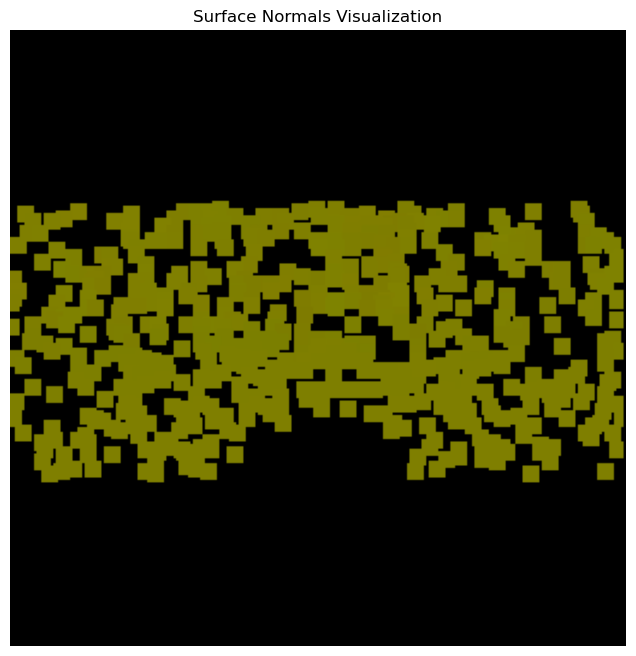

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def sn_image_from_npy(sn_np, raw_cam_img_size, px=20):
    sn_img = np.zeros((raw_cam_img_size[0], raw_cam_img_size[1], 3)) - 1
    for i in range(sn_np.shape[0]):
        y_min, y_max = np.maximum(0, int(sn_np[i, 0]) - px), np.minimum(raw_cam_img_size[0] - 1, int(sn_np[i, 0]) + px + 1)
        x_min, x_max = np.maximum(0, int(sn_np[i, 1]) - px), np.minimum(raw_cam_img_size[1] - 1, int(sn_np[i, 1]) + px + 1)
        sn_img[y_min:y_max, x_min:x_max, :] = sn_np[i, 2:]
    return sn_img

# Path to your .npy file
npy_path = "/mnt/sbackup/Server_3/harshr/home/FtFoot-main/data_ftfoot/ORFD-custom/training/surface_normal/WC1_2024-08-27_21-29-14_chunk0006/352_sparse.npy"

# Load the numpy file
sn_np = np.load(npy_path)

# Define your image dimensions (height, width)
img_height = 256  # Replace with your actual image height
img_width = 256   # Replace with your actual image width
raw_cam_img_size = (img_height, img_width)

# Generate the surface normal image
sn_img = sn_image_from_npy(sn_np, raw_cam_img_size, px=3)

# Normalize to 0-1 range for visualization
sn_img_normalized = (sn_img + 1) / 2

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(sn_img_normalized)
plt.title("Surface Normals Visualization")
plt.axis('off')
plt.show()


In [2]:
import os

def find_empty_folders(path):
    empty_folders = []
    
    for root, dirs, files in os.walk(path):
        # Check if the directory is empty (no files and no subdirectories)
        if not dirs and not files:
            empty_folders.append(root)
    
    return empty_folders

# Usage example
directory_path = "/mnt/sbackup/Server_3/harshr/m2p2_data_bags/G1_elev_dlio/data"
empty_dirs = find_empty_folders(directory_path)

# Print results
if empty_dirs:
    print("Empty folders found:")
    folder_list = []
    for folder in empty_dirs:
        print(folder)
        if 'depth_LBR' in folder:
            folder_list.append(folder)
    print(sorted(folder_list))
else:
    print("No empty folders found.")


No empty folders found.


## Data splitting

In [ ]:
# Use this to split the data correctly

import os
import pickle
import random
import shutil
from pathlib import Path
from tqdm import tqdm
import re

def split_dataset(source_dir, train_dir, val_dir, train_ratio=0.8, seed=42):
    random.seed(seed)
    
    # Create target directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Find all pickle files
    pkl_files = list(Path(source_dir).glob("*.pkl"))
    random.shuffle(pkl_files)
    
    # Split files
    split_idx = int(len(pkl_files) * train_ratio)
    train_files = pkl_files[:split_idx]
    val_files = pkl_files[split_idx:]
    
    print(f"Splitting {len(pkl_files)} files into {len(train_files)} train and {len(val_files)} validation files")
    
    # Process train and validation sets
    process_files(train_files, train_dir, source_dir, "Training")
    process_files(val_files, val_dir, source_dir, "Validation")

def process_files(files, target_dir, source_dir, split_name):
    path_keys = [
        'thermal_paths', 'depth_paths', 'sparse_depth_paths', 'elevation_raw_paths',
        'elevation_image_paths', 'traversability_mask_paths', 'traversability_footprint_paths'
    ]
    
    for pkl_file in tqdm(files, desc=f"Processing {split_name} files"):
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
        
        new_data = data.copy()
        
        for key in path_keys:
            if key in data:
                paths = data[key]
                if isinstance(paths, list):
                    new_paths = []
                    for path in paths:
                        if path is not None:
                            new_path = update_path(path, source_dir, target_dir)
                            new_paths.append(new_path)
                        else:
                            new_paths.append(None)
                    new_data[key] = new_paths
                elif paths is not None:
                    new_data[key] = update_path(paths, source_dir, target_dir)
        
        # Save updated pickle file
        new_pkl_path = os.path.join(target_dir, pkl_file.name)
        with open(new_pkl_path, 'wb') as f:
            pickle.dump(new_data, f)

def update_path(path, source_dir, target_dir):
    if path is None:
        return None
    
    # Extract the relevant part of the path
    match = re.search(r'dataset/([^/]+)', path)
    if match:
        relevant_path = match.group(1)
        new_path = os.path.join(target_dir, relevant_path, os.path.basename(path))
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        # Copy the file
        source_path = os.path.join(source_dir, relevant_path, os.path.basename(path))
        if os.path.exists(source_path):
            shutil.copy2(source_path, new_path)
        else:
            print(f"Warning: Source file not found: {source_path}")
        
        return new_path
    else:
        print(f"Warning: Unexpected path format: {path}")
        return path

# Configuration
source_dir = "/mnt/sbackup/Server_3/harshr/m2p2_data_bags/burke_lake_bags/Dataset"
train_dir = "/mnt/sbackup/Server_3/harshr/m2p2_data_elev/train"
val_dir = "/mnt/sbackup/Server_3/harshr/m2p2_data_elev/validation"
train_ratio = 0.8
seed = 42

# Run the splitting script
split_dataset(source_dir, train_dir, val_dir, train_ratio, seed)


Splitting 59 files into 47 train and 12 validation files


Processing Validation files: 100%|██████████| 12/12 [04:54<00:00, 24.58s/it]


In [ ]:
import os
import shutil
import pickle
import random
from pathlib import Path
from tqdm.auto import tqdm

def count_images_in_folders(folder_path, folder_prefix):
    """Count the total number of images inside folders with a specific prefix."""
    total_images = 0
    for folder in Path(folder_path).glob(f"{folder_prefix}*"):
        if folder.is_dir():
            image_count = len(list(folder.glob("*.png")))  # Assuming images are .png
            total_images += image_count
    return total_images

def display_stats(directory, split_name):
    """Display stats on the number of pkl files, thermal/depth/elevation folders, and images."""
    pkl_files = list(Path(directory).glob("*.pkl"))

    # Find unique thermal, depth, and elevation folder names from the pkl files:
    thermal_folders = set()
    depth_folders = set()
    elevation_folders = set()
    total_thermal_images = 0
    total_depth_images = 0
    total_elevation_images = 0

    for pkl_file in pkl_files:
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
            
            # Extract folder names and count images from data in pkl file:
            if data['thermal_paths']:
                thermal_folder = os.path.dirname(data['thermal_paths'][0]).split('/')[-1]
                thermal_folders.add(thermal_folder)
                total_thermal_images += len(data['thermal_paths'])
                
            # if data['depth_paths']:
            #     depth_folder = os.path.dirname(data['depth_paths'][0]).split('/')[-1]
            #     depth_folders.add(depth_folder)
            #     total_depth_images += len(data['depth_paths'])
                
            # if data['elevation_image_paths']:
            #     elevation_folder = os.path.dirname(data['elevation_image_paths'][0]).split('/')[-1]
            #     elevation_folders.add(elevation_folder)
            #     total_elevation_images += len(data['elevation_image_paths'])

    print(f"\nStats for {split_name}:")
    print(f"  Number of pkl files: {len(pkl_files)}")
    print(f"  Number of Thermal folders: {len(thermal_folders)}")
    # print(f"  Number of Depth folders: {len(depth_folders)}")
    # print(f"  Number of Elevation folders: {len(elevation_folders)}")
    print(f"  Total Thermal images: {total_thermal_images}")
    # print(f"  Total Depth images: {total_depth_images}")
    # print(f"  Total Elevation images: {total_elevation_images}")
    print(f"  Total images (Thermal + Depth + Elevation): {total_thermal_images }\n") #+ total_depth_images + total_elevation_images}\n")

    return total_thermal_images #+ total_depth_images + total_elevation_images


def split_dataset(source_dir, train_dir, val_dir, train_ratio=0.8, seed=42):
    random.seed(seed)
    
    pkl_files = list(Path(source_dir).glob("*.pkl"))
    print("Scanning for pkl files...")
        
    # Randomly split pkl files
    random.shuffle(pkl_files)
    split_idx = int(len(pkl_files) * train_ratio)
    train_pkl_files = pkl_files[:split_idx]
    val_pkl_files = pkl_files[split_idx:]
    print(f"Randomly split {len(pkl_files)} pkl files into {len(train_pkl_files)} train and {len(val_pkl_files)} validation files")
    
    # Create train and val directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    def process_split(pkl_files, target_dir, is_train=True):
        split_name = "train" if is_train else "validation"
        
        for pkl_file in tqdm(pkl_files, desc=f"Processing {split_name} split", unit="file"):
            # Get base name without extension
            base_name = pkl_file.stem
            
            # Copy and update pkl file
            with pkl_file.open("rb") as f:
                data = pickle.load(f)
            
            # Update paths in pkl file
            updated_data = data.copy()
            
            # Update thermal paths
            thermal_paths = data['thermal_paths']
            if thermal_paths:
                old_thermal_folder = os.path.dirname(thermal_paths[0]).split('/')[-1]
                updated_thermal_paths = [
                    os.path.join(target_dir, old_thermal_folder, os.path.basename(p))
                    for p in thermal_paths
                ]
                updated_data['thermal_paths'] = updated_thermal_paths
                
                # Copy thermal folder
                if os.path.exists(os.path.join(source_dir, old_thermal_folder)):
                    shutil.copytree(
                        os.path.join(source_dir, old_thermal_folder),
                        os.path.join(target_dir, old_thermal_folder),
                        dirs_exist_ok=True
                    )
            
            # Update depth paths
            # depth_paths = data['depth_paths']
            # if depth_paths:
            #     old_depth_folder = os.path.dirname(depth_paths[0]).split('/')[-1]
            #     updated_depth_paths = [
            #         os.path.join(target_dir, old_depth_folder, os.path.basename(p))
            #         for p in depth_paths
            #     ]
            #     updated_data['depth_paths'] = updated_depth_paths
                
            #     # Copy depth folder
            #     if os.path.exists(os.path.join(source_dir, old_depth_folder)):
            #         shutil.copytree(
            #             os.path.join(source_dir, old_depth_folder),
            #             os.path.join(target_dir, old_depth_folder),
            #             dirs_exist_ok=True
            #         )
            
            # # Update elevation paths
            # elevation_paths = data['elevation_image_paths']
            # if elevation_paths:
            #     old_elevation_folder = os.path.dirname(elevation_paths[0]).split('/')[-1]
            #     updated_elevation_paths = [
            #         os.path.join(target_dir, old_elevation_folder, os.path.basename(p))
            #         for p in elevation_paths
            #     ]
            #     updated_data['elevation_image_paths'] = updated_elevation_paths
                
            #     # Copy elevation folder
            #     if os.path.exists(os.path.join(source_dir, old_elevation_folder)):
            #         shutil.copytree(
            #             os.path.join(source_dir, old_elevation_folder),
            #             os.path.join(target_dir, old_elevation_folder),
            #             dirs_exist_ok=True
            #         )
            
            # Save updated pkl file
            npkl_path = os.path.join(target_dir, pkl_file.name)
            with open(npkl_path, "wb") as f:
                pickle.dump(updated_data, f)
    
    # Process train and validation splits
    print("\nProcessing training split...")
    process_split(train_pkl_files, train_dir, is_train=True)
    
    print("\nProcessing validation split...")
    process_split(val_pkl_files, val_dir, is_train=False)
    
    print("\nCalculating dataset statistics...")
    train_images = display_stats(train_dir, "Training")
    val_images = display_stats(val_dir, "Validation")
    
    print(f"Total images in Training: {train_images}")
    print(f"Total images in Validation: {val_images}")
    print(f"Total images in the dataset: {train_images + val_images}")

# Example usage
source_directory = "/mnt/sbackup/Server_3/harshr/m2p2_data_bags/burke_lake_bags/Dataset4"
train_directory = "/mnt/sbackup/Server_3/harshr/bc_data2/train"
val_directory = "/mnt/sbackup/Server_3/harshr/bc_data2/validation/"

split_dataset(source_directory, train_directory, val_directory)

Scanning for pkl files...
Randomly split 68 pkl files into 54 train and 14 validation files

Processing training split...


Processing train split:   0%|          | 0/54 [00:00<?, ?file/s]

KeyError: 'depth_paths'

In [6]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm

source_dir = Path("/mnt/sbackup/Server_3/harshr/m2p2_data_bags/burke_lake_bags/Dataset4")
output_dir = Path("/mnt/sbackup/Server_3/harshr/bc_data2")

train_ratio = 0.8
seed = 42

# Find pickle files
pkl_files = sorted(source_dir.glob("*_dataset.pkl"))
if not pkl_files:
    raise FileNotFoundError("No pickle files found")

import random
random.seed(seed)
random.shuffle(pkl_files)

split_idx = int(len(pkl_files)*train_ratio)
train_pkl = pkl_files[:split_idx]
val_pkl = pkl_files[split_idx:]

(train_dir := output_dir / "train").mkdir(parents=True, exist_ok=True)
(val_dir := output_dir / "validation").mkdir(parents=True, exist_ok=True)

(train_imgs_dir := train_dir / "thermal_images").mkdir(parents=True, exist_ok=True)
(val_imgs_dir := val_dir / "thermal_images").mkdir(parents=True, exist_ok=True)

def copy_data(pkl_list, target_dir, imgs_dir):
    for pkl_path in tqdm(pkl_list):
        shutil.copy2(pkl_path, target_dir / pkl_path.name)

        prefix = pkl_path.stem.replace("_dataset", "")  # e.g. LR_..._chunk0000_processed
        # glob matching all images with this prefix in *any* images folder under source_dir
        # Adjust this path if images are in a subfolder named after the bag inside source_dir

        img_folder = source_dir / "thermal_images"
        if not img_folder.exists():
            print(f"Image folder {img_folder} does not exist")
            continue

        # Find images matching prefix + "_*.png"
        pattern = f"{prefix}_*.png"
        matched_imgs = list(img_folder.glob(pattern))

        if len(matched_imgs) == 0:
            print(f"No images found for {prefix}")

        for img_path in matched_imgs:
            # Copy to the imgs_dir with existing filename
            shutil.copy2(img_path, imgs_dir / img_path.name)

copy_data(train_pkl, train_dir, train_imgs_dir)
copy_data(val_pkl, val_dir, val_imgs_dir)

100%|██████████| 14/14 [02:40<00:00, 11.46s/it]


In [1]:
import os
import shutil
import pickle
import random
from pathlib import Path
from tqdm.auto import tqdm

def count_images_in_folders(folder_path, folder_prefix):
    """Count the total number of images inside folders with a specific prefix."""
    total_images = 0
    for folder in Path(folder_path).glob(f"{folder_prefix}*"):
        if folder.is_dir():
            image_count = len(list(folder.glob("*.png")))  # Assuming images are .png
            total_images += image_count
    return total_images

def display_stats(directory, split_name):
    """Display stats on the number of pkl files, thermal/depth folders, and images."""
    pkl_files = list(Path(directory).glob("*.pkl"))
    thermal_folders = list(Path(directory).glob("thermal_*"))
    depth_folders = list(Path(directory).glob("depth_*"))
    
    thermal_images = count_images_in_folders(directory, "thermal_")
    depth_images = count_images_in_folders(directory, "depth_")
    
    print(f"\nStats for {split_name}:")
    print(f"  Number of pkl files: {len(pkl_files)}")
    print(f"  Number of Thermal folders: {len(thermal_folders)}")
    print(f"  Number of Depth folders: {len(depth_folders)}")
    print(f"  Total Thermal images: {thermal_images}")
    print(f"  Total Depth images: {depth_images}")
    print(f"  Total images (Thermal + Depth): {thermal_images + depth_images}\n")
    
    return thermal_images + depth_images


def split_dataset(source_dir, train_dir, val_dir, train_ratio=0.8, seed=42):
    random.seed(seed)
    
    pkl_files = list(Path(source_dir).glob("*.pkl"))
    print("Scanning for pkl files...")
        
    # Randomly split pkl files
    random.shuffle(pkl_files)
    split_idx = int(len(pkl_files) * train_ratio)
    train_pkl_files = pkl_files[:split_idx]
    val_pkl_files = pkl_files[split_idx:]
    print(f"Randomly split {len(pkl_files)} pkl files into {len(train_pkl_files)} train and {len(val_pkl_files)} validation files")
    
    # Create train and val directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    def process_split(pkl_files, target_dir, is_train=True):
        split_name = "train" if is_train else "validation"
        
        for pkl_file in tqdm(pkl_files, desc=f"Processing {split_name} split", unit="file"):
            # Get base name without extension
            base_name = pkl_file.stem
            
            # Copy and update pkl file
            with pkl_file.open("rb") as f:
                data = pickle.load(f)
            
            # Update paths in pkl file
            updated_data = data.copy()
            
            # Update thermal paths
            thermal_paths = data['thermal_paths']
            if thermal_paths:
                old_thermal_folder = os.path.dirname(thermal_paths[0]).split('/')[-1]
                updated_thermal_paths = [
                    os.path.join(target_dir, old_thermal_folder, os.path.basename(p))
                    for p in thermal_paths
                ]
                updated_data['thermal_paths'] = updated_thermal_paths
                
                # Copy thermal folder
                if os.path.exists(os.path.join(source_dir, old_thermal_folder)):
                    shutil.copytree(
                        os.path.join(source_dir, old_thermal_folder),
                        os.path.join(target_dir, old_thermal_folder),
                        dirs_exist_ok=True
                    )
            
            # Update depth paths
            depth_paths = data['depth_paths']
            if depth_paths:
                old_depth_folder = os.path.dirname(depth_paths[0]).split('/')[-1]
                updated_depth_paths = [
                    os.path.join(target_dir, old_depth_folder, os.path.basename(p))
                    for p in depth_paths
                ]
                updated_data['depth_paths'] = updated_depth_paths
                
                # Copy depth folder
                if os.path.exists(os.path.join(source_dir, old_depth_folder)):
                    shutil.copytree(
                        os.path.join(source_dir, old_depth_folder),
                        os.path.join(target_dir, old_depth_folder),
                        dirs_exist_ok=True
                    )
            
            # Save updated pkl file
            npkl_path = os.path.join(target_dir, pkl_file.name)
            with open(npkl_path, "wb") as f:
                pickle.dump(updated_data, f)
    
    # Process train and validation splits
    print("\nProcessing training split...")
    process_split(train_pkl_files, train_dir, is_train=True)
    
    print("\nProcessing validation split...")
    process_split(val_pkl_files, val_dir, is_train=False)
    
    print("\nCalculating dataset statistics...")
    train_images = display_stats(train_dir, "Training")
    val_images = display_stats(val_dir, "Validation")
    
    print(f"Total images in Training: {train_images}")
    print(f"Total images in Validation: {val_images}")
    print(f"Total images in the dataset: {train_images + val_images}")

# Example usage
source_directory = "/mnt/sbackup/Server_3/harshr/m2p2_data_bags/burke_lake_bags/Dataset"
train_directory = "/mnt/sbackup/Server_3/harshr/m2p2_data2/train/"
val_directory = "/mnt/sbackup/Server_3/harshr/m2p2_data2/validation/"

split_dataset(source_directory, train_directory, val_directory)


Scanning for pkl files...
Randomly split 139 pkl files into 111 train and 28 validation files

Processing training split...


Processing train split:   0%|          | 0/111 [00:00<?, ?file/s]


Processing validation split...


Processing validation split:   0%|          | 0/28 [00:00<?, ?file/s]


Calculating dataset statistics...

Stats for Training:
  Number of pkl files: 111
  Number of Thermal folders: 111
  Number of Depth folders: 111
  Total Thermal images: 87153
  Total Depth images: 0
  Total images (Thermal + Depth): 87153


Stats for Validation:
  Number of pkl files: 28
  Number of Thermal folders: 28
  Number of Depth folders: 28
  Total Thermal images: 19903
  Total Depth images: 0
  Total images (Thermal + Depth): 19903

Total images in Training: 87153
Total images in Validation: 19903
Total images in the dataset: 107056


## Check pickle file for odom and thermal data

In [12]:
import pickle
import pandas as pd
# file_path ='/home/harshr/NV_cahsor/CAHSOR-master/data/subset.pkl'
file_path ='/home/harshr/NV_cahsor/data/traversability/BL_2024-09-04_19-10-17_chunk0001.pkl'

try:
    # For large files, you can load just a sample
    with open(file_path, 'rb') as file:
        data = pickle.load(file)

    print(data['thermal_npaths'][0])
    
    # If it's a DataFrame
    if isinstance(data, pd.DataFrame):
        # Get basic information about the DataFrame
        print("Data shape:", data.shape)
        
        # Check for empty columns
        empty_cols = [col for col in data.columns if data[col].isna().all()]
        print(f"Empty columns: {empty_cols if empty_cols else 'None'}")
        
        # Get data types of each column
        print("\nColumn data types:")
        print(data.dtypes)
        
        # Show a small sample (first 5 rows)
        print("\nSample data (first 5 rows):")
        print(data.head())
        
        # Get basic statistics for numeric columns
        print("\nNumeric column statistics:")
        print(data.describe())
        
        # For non-numeric columns, show unique values count
        for col in data.select_dtypes(exclude=['number']).columns:
            unique_count = data[col].nunique()
            print(f"\nColumn '{col}' has {unique_count} unique values")
            if unique_count < 10:  # Only show values if there aren't too many
                print(data[col].value_counts().head())
    
    # If it's a dictionary
    elif isinstance(data, dict):
        print("Dictionary with keys:", list(data.keys()))
        for key, value in data.items():
            print(f"\nKey: {key}")
            print(f"Type: {type(value)}")
            if hasattr(value, 'shape'):
                print(f"Shape: {value.shape}")
            elif isinstance(value, list):
                print(f"List length: {len(value)}")
                if len(value) > 0:
                    print(f"First element type: {type(value[0])}")
    
    # For other data types
    else:
        print(f"Data type: {type(data)}")
        # Try to get some basic info based on the type
        if hasattr(data, '__len__'):
            print(f"Length: {len(data)}")
        
except FileNotFoundError:
    print(f"File not found: {file_path}")
except Exception as e:
    print(f"Error loading pickle file: {e}")


/home/harshr/NV_cahsor/data/traversability/thermal_BL_2024-09-04_19-10-17_chunk0001/thermal_1725491417.074790.png
Dictionary with keys: ['thermal_npaths', 'thermal_timestamps', 'odom_poses', 'odom_timestamps']

Key: thermal_npaths
Type: <class 'list'>
List length: 600
First element type: <class 'str'>

Key: thermal_timestamps
Type: <class 'list'>
List length: 600
First element type: <class 'float'>

Key: odom_poses
Type: <class 'list'>
List length: 3001
First element type: <class 'dict'>

Key: odom_timestamps
Type: <class 'list'>
List length: 3001
First element type: <class 'float'>


In [2]:
import torch
import argparse
import os
from rich.console import Console
from rich.table import Table

def inspect_checkpoint(checkpoint_path: str):
    """
    Loads a PyTorch checkpoint and prints its contents in a readable format.

    Args:
        checkpoint_path (str): The full path to the .pth or .pt checkpoint file.
    """
    console = Console()

    # --- 1. Validate File Path ---
    if not os.path.exists(checkpoint_path):
        console.print(f"[bold red]Error:[/bold red] File not found at '{checkpoint_path}'")
        return

    console.print(f"\nInspecting checkpoint: [bold cyan]{os.path.basename(checkpoint_path)}[/bold cyan]")
    
    # --- 2. Load the Checkpoint ---
    try:
        # Use map_location='cpu' to load models saved on GPU onto a CPU-only machine
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        if not isinstance(checkpoint, dict):
            console.print("[bold red]Error:[/bold red] Checkpoint is not a dictionary. Cannot inspect.")
            return
    except Exception as e:
        console.print(f"[bold red]Error loading checkpoint:[/bold red] {e}")
        return

    # --- 3. Create and Populate the Information Table ---
    table = Table(title="Checkpoint Details")
    table.add_column("Key", style="magenta", justify="right")
    table.add_column("Value", style="green")

    for key, value in checkpoint.items():
        # Handle large state dictionaries separately to avoid printing huge tensors
        if key in ['model', 'vision_encoder', 'imu_encoder', 'optimizer']:
            if isinstance(value, dict):
                num_keys = len(value.keys())
                table.add_row(key, f"State dictionary with [bold yellow]{num_keys}[/bold yellow] keys")
            else:
                 table.add_row(key, "Present (format not a dict)")
        
        # Handle loss lists to show summary info
        elif 'loss' in key and isinstance(value, list):
            if value: # Check if the list is not empty
                num_entries = len(value)
                last_loss = value[-1]
                table.add_row(f"Final {key}", f"{last_loss:.6f} ([bold yellow]{num_entries}[/bold yellow] total entries)")
            else:
                table.add_row(key, "Empty list []")
        
        # Handle the configuration object
        elif key == 'cfg':
            table.add_row(key, "Configuration object is present.")
        
        # For all other simple key-value pairs
        else:
            table.add_row(key, str(value))
    
    console.print(table)



inspect_checkpoint('/mnt/sbackup/Server_3/harshr/home/NV_cahsor/CAHSOR-master/TRON/checkpoint/tron/ssl-ptr-thermal_lidar_video_2/SBT_Plan1-2048-09-02-18-40/best_model.pth')

Inspecting checkpoint: best_model.pth

/tmp/ipykernel_736783/1313689208.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


                    Checkpoint Details                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃ Value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                time │ 2025-09-03 01:45:50.372806       │
│               epoch │ 97                               │
│           iteration │ 27063                            │
│               model │ State dictionary with 335 keys   │
│      vision_encoder │ State dictionary with 318 keys   │
│           optimizer │ State dictionary with 2 keys     │
│      optimizer_name │ AdamW                            │
│           best_loss │ 202.23689713016634               │
│        Final e_loss │ 202.236897 (78 total entries)    │
│ Final barlow_losses │ 204.811203 (19 total entries)    │
│                 cfg │ Configuration object is present. │
└─────────────────────┴──────────────────────────────────┘